### Modelo de Machine Learning que prevê churn (evasão de clientes) para uma empresa de telefonia.
#### O código envolve limpeza de dados, Análise Exploratória de Dados (AED), treinamento do modelo e avaliação usando métricas como AUC, precisão e recall.



In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


In [22]:
# 1. Carregar o dataset
clientes = pd.read_csv('Data/clientes.csv')

# 2. Exploração inicial dos dados
print(clientes.info())
print(clientes.describe())
print(clientes.isnull().sum())  # Verifica valores nulos


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5634 entries, 0 to 5633
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                5634 non-null   int64  
 1   gender            5634 non-null   object 
 2   SeniorCitizen     5634 non-null   int64  
 3   Partner           5634 non-null   object 
 4   Dependents        5416 non-null   object 
 5   tenure            5173 non-null   float64
 6   PhoneService      5634 non-null   object 
 7   MultipleLines     5634 non-null   object 
 8   InternetService   5634 non-null   object 
 9   OnlineSecurity    5634 non-null   object 
 10  OnlineBackup      5634 non-null   object 
 11  DeviceProtection  5634 non-null   object 
 12  TechSupport       5634 non-null   object 
 13  StreamingTV       5634 non-null   object 
 14  StreamingMovies   5634 non-null   object 
 15  Contract          5634 non-null   object 
 16  PaperlessBilling  5634 non-null   object 


In [24]:
# 3. Tratamento de dados ausentes
clientes['Dependents'] = clientes['Dependents'].fillna('No')
clientes['tenure']= clientes['tenure'].fillna(clientes['tenure'].median())
clientes['PaymentMethod']= clientes['PaymentMethod'].fillna(clientes['PaymentMethod'].mode()[0])

# Conversão de TotalCharges para numérico
clientes['TotalCharges'] = pd.to_numeric(clientes['TotalCharges'], errors='coerce')
clientes['TotalCharges']= clientes['TotalCharges'].fillna(clientes['TotalCharges'].median())

# 4. Remover colunas desnecessárias
clientes.drop('id', axis=1, inplace=True)


In [30]:
# 5. Separação de colunas categóricas e numéricas
categoricas = clientes.select_dtypes(include=['object']).columns.tolist()
numericas = clientes.select_dtypes(include=['int64', 'float64']).columns.tolist()
numericas.remove('Churn')

In [33]:
# 6. Transformação de dados (OneHotEncoder para categóricas e StandardScaler para numéricas)
transformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoricas)
    ]
)

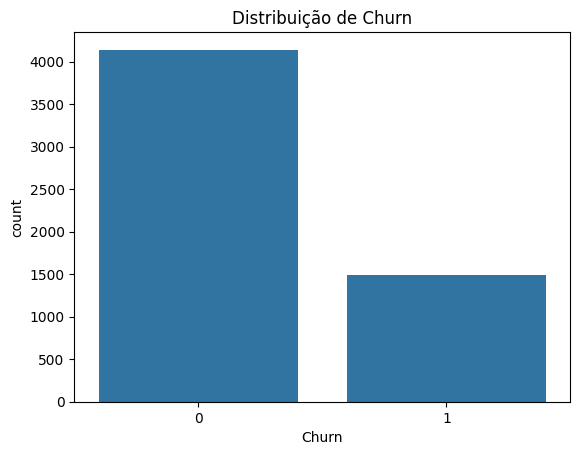

In [34]:
# 7. Análise Exploratória de Dados (visualização de churn)
sns.countplot(x='Churn', data=clientes)
plt.title('Distribuição de Churn')
plt.show()

In [35]:
# Matriz de correlação - Codificar variáveis categóricas temporariamente para evitar erro
clientes_encoded = clientes.copy()
clientes_encoded[categoricas] = clientes_encoded[categoricas].apply(lambda x: pd.factorize(x)[0])


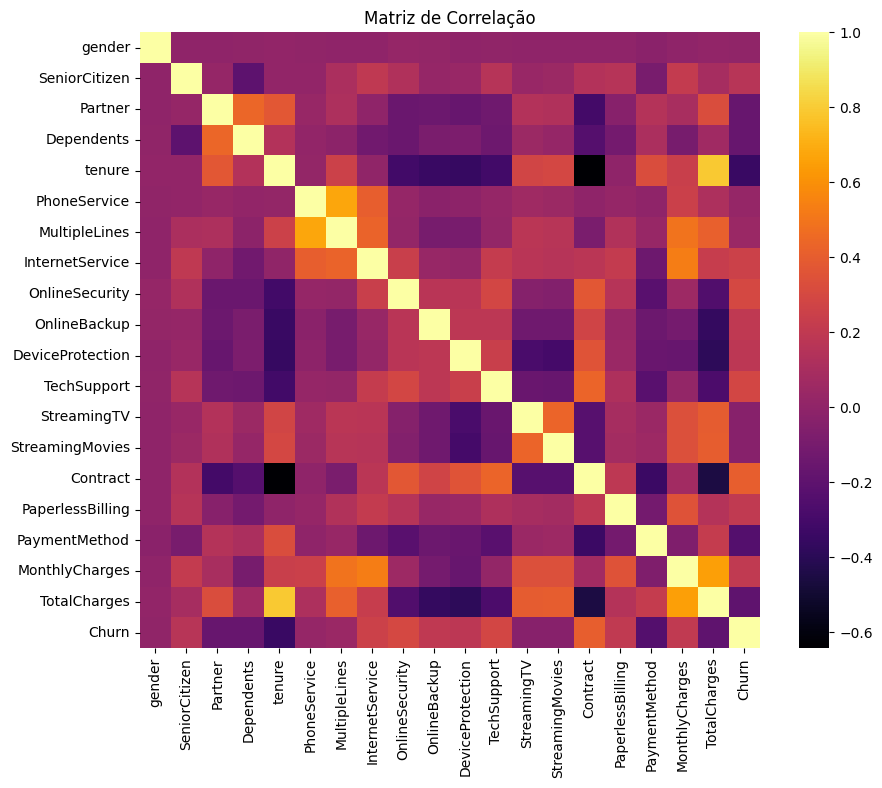

In [38]:
plt.figure(figsize=(10,8))
sns.heatmap(clientes_encoded.corr(), cmap='inferno')
plt.title('Matriz de Correlação')
plt.show()

In [39]:
# 8. Divisão dos dados (treino/teste)
X = clientes.drop('Churn', axis=1)
y = clientes['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [40]:
# 9. Aplicar transformações
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)


In [41]:
# 10. Modelos de Machine Learning
modelos = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

parametros_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

resultados = {}

for nome, modelo in modelos.items():
    if nome == 'Random Forest':
        grid_search = GridSearchCV(modelo, parametros_rf, cv=5, scoring='roc_auc')
        grid_search.fit(X_train, y_train)
        melhor_modelo = grid_search.best_estimator_
    else:
        melhor_modelo = modelo.fit(X_train, y_train)
    
    predicoes = melhor_modelo.predict(X_test)
    predicoes_proba = melhor_modelo.predict_proba(X_test)[:, 1] if hasattr(melhor_modelo, 'predict_proba') else predicoes
    
    resultados[nome] = {
        'classification_report': classification_report(y_test, predicoes),
        'roc_auc': roc_auc_score(y_test, predicoes_proba),
        'accuracy': accuracy_score(y_test, predicoes)
    }
    
    print(f"\nModelo: {nome}")
    print(resultados[nome]['classification_report'])
    print(f"AUC: {resultados[nome]['roc_auc']}")
    print(f"Acurácia: {resultados[nome]['accuracy']}")

/home/joelct/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Modelo: Random Forest
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       839
           1       0.66      0.52      0.58       288

    accuracy                           0.81      1127
   macro avg       0.75      0.71      0.73      1127
weighted avg       0.80      0.81      0.80      1127

AUC: 0.8466345517150047
Acurácia: 0.808340727595386

Modelo: Naive Bayes
              precision    recall  f1-score   support

           0       0.92      0.66      0.77       839
           1       0.46      0.83      0.59       288

    accuracy                           0.71      1127
   macro avg       0.69      0.75      0.68      1127
weighted avg       0.80      0.71      0.72      1127

AUC: 0.8101700105946231
Acurácia: 0.7062999112688554

Modelo: Decision Tree
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       839
           1       0.48      0.50      0.49       288

    accura

In [ ]:
# 8. Modelos de Machine Learning
modelos = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}

parametros = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'Decision Tree': {
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
}

resultados = {}

for nome, modelo in modelos.items():
    if nome in parametros:
        grid_search = GridSearchCV(modelo, parametros[nome], cv=5, scoring='roc_auc')
        grid_search.fit(X_train, y_train)
        melhor_modelo = grid_search.best_estimator_
    else:
        melhor_modelo = modelo.fit(X_train, y_train)
    
    predicoes = melhor_modelo.predict(X_test)
    predicoes_proba = melhor_modelo.predict_proba(X_test)[:, 1] if hasattr(melhor_modelo, 'predict_proba') else predicoes
    
    print(f"\nModelo: {nome}")
    print(classification_report(y_test, predicoes))
    print(f"AUC: {roc_auc_score(y_test, predicoes_proba)}")
    print(f"Acurácia: {accuracy_score(y_test, predicoes)}")
    
    resultados[nome] = {
        'modelo': melhor_modelo,
        'AUC': roc_auc_score(y_test, predicoes_proba),
        'Acurácia': accuracy_score(y_test, predicoes)
    }

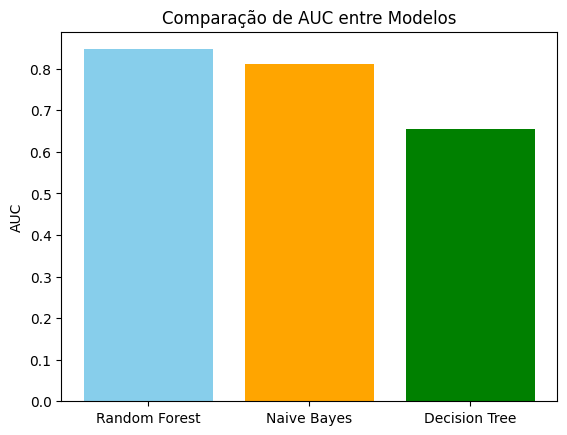

In [42]:
# Comparação visual dos modelos
auc_scores = [resultados[m]['roc_auc'] for m in resultados]
plt.bar(resultados.keys(), auc_scores, color=['skyblue', 'orange', 'green'])
plt.title('Comparação de AUC entre Modelos')
plt.ylabel('AUC')
plt.show()